In [1]:
import math
import random
from typing import Any, Callable, Self

import matplotlib.pyplot as plt
import numpy as np
from IPython.display import HTML
from matplotlib import animation 

In [2]:
class Gene:
    def __init__(
        self,
        chromosome: list = None,
        chromosome_length: int = None,
        boundaries: tuple[float, float] = None,
    ) -> None:
        if chromosome is not None:
            self.chromosome = chromosome
        else:
            self.chromosome = [
                random.uniform(boundaries[0], boundaries[1])
                for _ in range(chromosome_length)
            ]

    def __repr__(self) -> str:
        return str(self.chromosome)

    def apply_function(self, func: Callable) -> Any:
        return func(self.chromosome)

    def crossover(self, gene: Self) -> Self:
        new_chromosome = []
        for first, second in zip(self.chromosome, gene.chromosome):
            new_chromosome.append(first if random.randint(0, 1) == 0 else second)

        return Gene(new_chromosome)

    def mutate(self, mutation_limit: float, boundaries: tuple[float, float]) -> Self:
        mutated_position = random.randrange(len(self.chromosome))
        mutation = random.uniform(-mutation_limit, mutation_limit)

        new_chromosome = self.chromosome.copy()
        mutated_value = new_chromosome[mutated_position] + mutation
        mutated_value = min(boundaries[1], max(boundaries[0], mutated_value))
        new_chromosome[mutated_position] = mutated_value

        return Gene(new_chromosome)

In [3]:
class Population:
    def __init__(self, genes: list[Gene]):
        self.genes = genes
        self.pareto = [None] * len(genes)   
        self.max_pareto = None

    def spawn_children(self, mutation_limit):
        for child_i in range(CHILDREN_NUMBER):
            parent_1 = self.genes[random.randrange(POPULATION_SIZE)]
            parent_2 = self.genes[random.randrange(POPULATION_SIZE)]
            child = parent_1.crossover(parent_2).mutate(
                mutation_limit=mutation_limit, boundaries=BOUNDARIES
            )
            self.genes.append(child)
            self.pareto.append(None)

    def update_pareto(self, limit: int = None):
        if self.max_pareto is not None:
            self.pareto = [None] * len(self.genes)
        if limit is None:
            limit = len(self.genes)

        current_front = 0
        number_of_sorted_genes = 0
        while number_of_sorted_genes < limit:
            for i, gene in enumerate(self.genes):
                if self.pareto[i] is not None:
                    continue
                if self.is_non_dominated(gene, current_front):
                    self.pareto[i] = current_front
                    number_of_sorted_genes += 1
            current_front += 1

        self.max_pareto = current_front - 1

    def filter_by_pareto_number(
        self,
        pareto_number: int,
        comp_function: Callable,
        sort: bool = False
    ) -> list[Gene]:
        filtered_genes = []
        for gene, pareto in zip(self.genes, self.pareto):
            if pareto is not None and comp_function(pareto, pareto_number):
                filtered_genes.append(gene)
                
        if sort:
            return sorted(filtered_genes, key=apply_f1)
        return filtered_genes

    def is_non_dominated(
        self,
        gene: Gene,
        current_front: int
    ) -> bool:
        for population_gene, population_front in zip(self.genes, self.pareto):
            if population_front is not None and population_front != current_front:
                continue
            if apply_f1(population_gene) < apply_f1(gene) and apply_f2(population_gene) <= apply_f2(gene):
                return False
            if apply_f1(population_gene) <= apply_f1(gene) and apply_f2(population_gene) < apply_f2(gene):
                return False
        return True

In [4]:
def f_1(x):
    sum = 0
    for x_i in x:
        sum += (x_i - 1 / np.sqrt(len(x))) ** 2
    return 1 - np.exp(-sum)

def f_2(x):
    sum = 0
    for x_i in x:
        sum += (x_i + 1 / np.sqrt(len(x))) ** 2
    return 1 - np.exp(-sum)

def apply_f1(gene):
    return gene.apply_function(f_1)

def apply_f2(gene):
    return gene.apply_function(f_2)

In [5]:
POPULATION_SIZE = 200
CHILDREN_NUMBER = 200
ITERATIONS_NUMBER = 20
BOUNDARIES = (-4, 4)
N = 2

In [6]:
def distance_sorting(genes: list[Gene]) -> list[Gene]:
    distance = [0] * len(genes)
    distance[0] = math.inf
    distance[-1] = math.inf

    for i in range(1, len(genes) - 1):
        for func in [apply_f1, apply_f2]:
            numerator = func(genes[i + 1]) - func(genes[i - 1])
            denominator = func(genes[0]) - func(genes[-1])
            distance[i] += abs(numerator / denominator)

    zip_sorted_by_distance = sorted(list(zip(genes, distance)), key=lambda x: -x[1])
    genes_sorted_by_distance = list(zip(*zip_sorted_by_distance))[0]
    
    return genes_sorted_by_distance

In [7]:
populations = [
    Population(
        [
            Gene(chromosome_length=N, boundaries=BOUNDARIES)
            for _ in range(POPULATION_SIZE)
        ]
    )
]

In [8]:
for iteration in range(ITERATIONS_NUMBER):
    print(iteration + 1)
    
    population = populations[-1]
    population.spawn_children(mutation_limit=0.1)
    population.update_pareto(POPULATION_SIZE)

    next_population_genes = population.filter_by_pareto_number(
        pareto_number=population.max_pareto,
        comp_function=lambda a, b: a < b,
    )
    insufficient_population = POPULATION_SIZE - len(next_population_genes)
    
    max_front_population_genes = population.filter_by_pareto_number(
        pareto_number=population.max_pareto,
        comp_function=lambda a, b: a == b,
        sort=True,
    )
    max_front_population_genes_sorted = distance_sorting(max_front_population_genes)
    next_population_genes += max_front_population_genes_sorted[:insufficient_population]

    populations.append(
        Population(next_population_genes)
    )
    
populations[-1].update_pareto(POPULATION_SIZE)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20


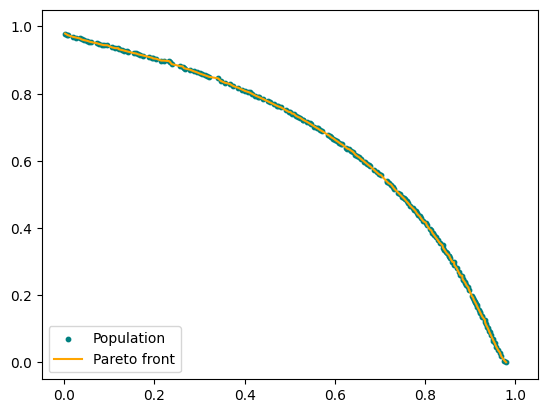

In [9]:
fig, ax = plt.subplots()

x = list(map(apply_f1, populations[-1].genes))
y = list(map(apply_f2, populations[-1].genes))
scatter = ax.scatter(x, y, s=10, c="teal", label="Population")
scatter_children = ax.scatter([], [], s=10, c="teal", alpha=0.2, label="Children")

first_front_population_genes = populations[-1].filter_by_pareto_number(
    pareto_number=0,
    comp_function=lambda a, b: a == b,
    sort=True,
)
x_pareto = list(map(apply_f1, first_front_population_genes))
y_pareto = list(map(apply_f2, first_front_population_genes))
plot = ax.plot(x_pareto, y_pareto, c="orange", label="Pareto front")[0]

ax.set_xlim([-0.05, 1.05])
ax.set_ylim([-0.05, 1.05])
ax.legend(handles=[scatter, plot], loc="lower left")

In [10]:
ax.legend(handles=[scatter, scatter_children, plot], loc="lower left")

def animation_func(frame):
    x = list(map(apply_f1, populations[frame].genes[:POPULATION_SIZE]))
    y = list(map(apply_f2, populations[frame].genes[:POPULATION_SIZE]))
    scatter.set_offsets(
        np.stack([x, y]).T
    )
    
    x_children = list(map(apply_f1, populations[frame].genes[POPULATION_SIZE:]))
    y_children = list(map(apply_f2, populations[frame].genes[POPULATION_SIZE:]))
    scatter_children.set_offsets(
        np.stack([x_children, y_children]).T
    )

    first_front_population_genes = populations[frame].filter_by_pareto_number(
        pareto_number=0,
        comp_function=lambda a, b: a == b,
        sort=True,
    )
    x_pareto = list(map(apply_f1, first_front_population_genes))
    y_pareto = list(map(apply_f2, first_front_population_genes))
    plot.set_xdata(x_pareto)
    plot.set_ydata(y_pareto)
    
ani = animation.FuncAnimation(fig=fig, func=animation_func, frames=len(populations), interval=500)
HTML(ani.to_jshtml())